This notebook contains all the code necessary to process the in-vivo analysis. A python file version of this notebook can be found in the code folder.

Importing relevant modules:

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

# Change directory to the code folder
os.chdir('../code')

# Import Dipy's procedures to process diffusion tensor
import dipy.reconst.dti as dti

# Import Dipy's functions that load and read CENIR data
from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib

# Import Dipy's brain segmentation function
from dipy.segment.mask import median_otsu

# Importing procedures to fit the free water elimination DTI model
from functions import nls_fit_tensor

Downloading data (note 1.7 Gb of data will be downloaded)...

In [2]:
# Download data using dipy's function fetch_cenir_multib
fetch_cenir_multib(with_raw=False)

# Select the b-values to read
bvals = [200, 400, 1000, 2000]

# Read data using dipy's function read_cenir_multib
img, gtab = read_cenir_multib(bvals)

# Read matrix containing data from img object
data = img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 


Estimate a brain mask...

In [3]:
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

Fitting the free water DTI model...

In [4]:
t0 = time.time()
fw_params = nls_fit_tensor(gtab, data, mask)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 2530.262000 seconds to run


C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 900.
  warnings.warn(errors[info][0], RuntimeWarning)


Compute tensor statistic from the fitted parameters...

In [5]:
# Extract tissue's diffusion tensor eigenvalues
evals = fw_params[..., :3]

# Extract free water volume fraction estimates
F = fw_params[..., 12]

# Compute the tissue's diffusion tensor fractional anisotropy
# using function fractional_anisotropy of Dipy's module dti
FA = dti.fractional_anisotropy(evals)

# Compute the tissue's diffusion tensor mean diffusivity
# using function mean_diffusivity of Dipy's module dti
MD = dti.mean_diffusivity(evals)

Compute standard DTI for comparison...

In [6]:
# Define the standard DTI model using Dipy's modules
# given the acquisition parameters that were read
dtimodel = dti.TensorModel(gtab)

# Fit DTI model in voxel pointed by the brain ROI
dtifit = dtimodel.fit(data, mask=mask_roi)

# Extract standard FA and MD from the DTI fitted parameters
dti_FA = dtifit.fa
dti_MD = dtifit.md

Plot data for a axial slice of the data ...

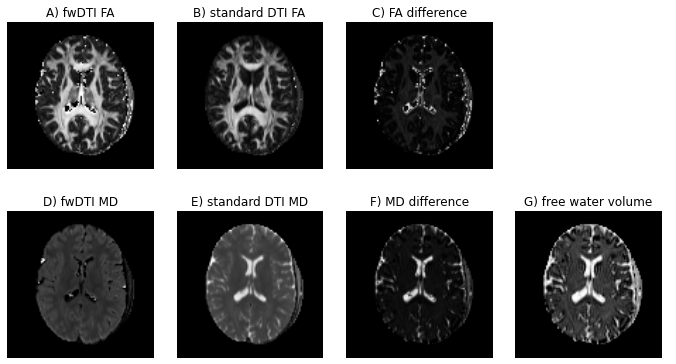

In [7]:
axial_slice = 40

fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.1)

# Plot fwDTI FA
im = ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[0].set_title('A) fwDTI FA')
fig1.colorbar(im, ax=ax.flat[0])

# Plot DTI FA
im = ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[1].set_title('B) standard DTI FA')
fig1.colorbar(im, ax=ax.flat[1])

# Plot DTI difference
FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
im = ax.flat[2].imshow(FAdiff.T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[2].set_title('C) FA difference')
fig1.colorbar(im, ax=ax.flat[2])

# Turn off the unnecessary panel
ax.flat[3].axis('off')

# Plot fwDTI MD
im =ax.flat[4].imshow(MD[:, :, axial_slice].T * 1000,
                      origin='lower', cmap='gray', vmin=0, vmax=2)
ax.flat[4].set_title('D) fwDTI MD')
fig1.colorbar(im, ax=ax.flat[4])

# Plot DTI MD
im = ax.flat[5].imshow(dti_MD[:, :, axial_slice].T * 1000,
                       origin='lower', cmap='gray', vmin=0, vmax=2)
ax.flat[5].set_title('E) standard DTI MD')
fig1.colorbar(im, ax=ax.flat[5])

# Plot MD difference
MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice]) * 1000
im =ax.flat[6].imshow(MDdiff.T, origin='lower',
                      cmap='gray', vmin=0, vmax=2)
ax.flat[6].set_title('F) MD difference')
fig1.colorbar(im, ax=ax.flat[6])

# Plot free water volume fraction
im = ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')
fig1.colorbar(im, ax=ax.flat[7])

plt.show()
fig1.savefig('fwdti_in_vivo.png', bbox_inches='tight')